[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GP248CME215/PINN_tf2/blob/main/1D_ODE_equation_25_spring_TF2.ipynb)





In [3]:
##############################################################################################################
# RUN THIS CODE BLOCK FIRST, it will load dependencies / install them if your system does not already have them.
##############################################################################################################

# tensorflow
try:
    # Try to import TensorFlow
    import tensorflow as tf
    print(f"TensorFlow is already installed. Version: {tf.__version__}")
except ImportError as e:
    # TensorFlow is not installed; install it
    print("TensorFlow is not installed. Installing TensorFlow...")
    !pip install tensorflow
    import tensorflow as tf
    print(f"Successfully installed TensorFlow. Version: {tf.__version__}")

# pyDOE
try:
    # Try to import pyDOE
    import pyDOE
    print(f"pyDOE is already installed.")
except ImportError as e:
    # pyDOE is not installed; install it
    print("pyDOE is not installed. Installing pyDOE...")
    !pip install pyDOE
    import pyDOE
    print(f"Successfully installed pyDOE.")


"""
@author: Yongji Wang, Yao Lai, Ray Chou (modified from Maziar Raissi)
"""
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(123)
tf.random.set_seed(123)

print(tf.__version__)

TensorFlow is already installed. Version: 2.18.0
pyDOE is not installed. Installing pyDOE...
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=ad31e5a8f96a1297a35b460a2ada83ceba59191c4fe59018977d0409bb90ea8f
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE
2.18.0


# Neural Network Implementation

In [5]:
class PhysicsInformedNN:
    # Initialize the class with training and validation data, network structure, and parameters
    def __init__(self, x_u, u, x_f, x_val, layers, lb, ub, gamma):
        # Lower and upper bounds of the input domain (used for normalization)
        self.lb = lb
        self.ub = ub

        # Supervised training data: locations and known values
        self.x_u = x_u  # Collocation points with known solution
        self.u = u      # Known solution values at x_u

        # Collocation points for enforcing the physics (residual of ODE)
        self.x_f = x_f

        # Validation points (used for monitoring generalization)
        self.x_val = x_val

        # Neural network architecture: list of neurons per layer
        self.layers = layers

        # Weight for the ODE loss (residual) in total loss
        self.gamma = gamma

        # Initialize network weights and biases
        self.weights, self.biases = self.initialize_NN(layers)

        # List of all trainable variables (used by optimizer)
        self.train_variables = self.weights + self.biases

        # # Compute initial loss (not strictly necessary here, could be deferred)
        # self.loss = self.loss_NN()

    '''
    Neural Network Initialization
    =============================
    '''

    # Initialize the weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Xavier initialization helps maintain signal variance across layers
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)


    def neural_net(self, X, weights, biases):
        """
        Function to construct the forward pass of the neural network
        Input:
        1. X: input tensor
        2. weights: All W matrixes, NN parameters
        3. biases: All b matrixes, NN parameters
        Output:
        1. Y: NN prediction
        """
        num_layers = len(weights) + 1
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0 #normalize the input to [-1, 1]
        #########################
        #########################
        ### YOUR CODE STARTS HERE (~7 lines, 6 points)
        ### Note: we do not apply activation function for the last layer


        ### YOUR CODE ENDS HERE
        #########################
        #########################

        return Y

    '''
    Physics-Informed Loss Construction
    ==================================
    '''

    # Predict the solution u(x) using the neural network
    def net_u(self, x):
        u = self.neural_net(x, self.weights, self.biases)
        return u

    #
    def net_f(self, x):
        """
        Function to Compute the ODE residual f = du/dx - u using automatic differentiation
        Output:
        1. f: equation residual
        """

        ### More details of tf.GradientTape() you can follow
        ### https://www.tensorflow.org/api_docs/python/tf/GradientTape
        with tf.GradientTape() as tape:
            tape.watch(x)
            u = self.net_u(x)
            #########################
            #########################
            ### YOUR CODE STARTS HERE (~2 lines, 3 points)


        ### YOUR CODE ENDS HERE
        #########################
        #########################
        return f

    @tf.function
    def loss_NN(self):
        """
        Function to compute the total loss: data loss + equation loss (weighted by gamma)
        Output:
        1. loss_d: data loss
        2. loss_e: equation loss
        3. loss: total loss
        """
        #########################
        #########################
        ### YOUR CODE STARTS HERE (~4 lines, 6 points)
        ### Hint: Use mean squared loss for both equation loss and data loss


        ### YOUR CODE ENDS HERE
        #########################
        #########################
        ### Congratulations, if you fill in the code blocks above right, you will able to
        ### reproduce the plots below simply running through the rest of the code blocks


        loss = loss_d + self.gamma * loss_e
        return loss, loss_d, loss_e

    # Train the model using Adam optimizer
    def train(self, nIter: int, learning_rate: float):
        """
        Function used for training the model using the Adam optimizer.
        Implements exponential decay for learning rate.
        Tracks training and validation loss at intervals.
        """

        # Learning rate schedule: exponential decay
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=400,
            decay_rate=0.8
        )
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        start_time = time.time()
        it_list = []          # Track training iterations
        loss_list = []        # Track total loss
        eq_loss_list = []     # Track equation loss
        val_it_list = []      # Validation iteration steps
        val_loss_list = []    # Validation loss values

        for it in range(nIter):
            with tf.GradientTape() as tape:
                loss, loss_d, loss_e = self.loss_NN()
                grads = tape.gradient(loss, self.train_variables)
                optimizer.apply_gradients(zip(grads, self.train_variables))

                it_list.append(it)
                loss_list.append(loss)
                eq_loss_list.append(loss_e)

            # Every 10 steps, evaluate validation loss and print status
            if (it + 1) % 10 == 0:
                residual = self.net_f(self.x_val)
                val_loss = tf.reduce_mean(tf.square(residual)) * self.gamma
                val_it_list.append(it)
                val_loss_list.append(val_loss)

                elapsed = time.time() - start_time
                print('It: %d, Train Loss: %.4e, Data Loss: %.4e, Eq Loss: %.4e, Val Loss: %.4e Time: %.2f' %
                      (it, loss.numpy(), loss_d.numpy(), loss_e.numpy(), val_loss.numpy(), elapsed))
                start_time = time.time()

        return it_list, loss_list, eq_loss_list, val_it_list, val_loss_list

    # Predict u and residual f for new input points
    @tf.function
    def predict(self, x):
        u_p = self.net_u(x)
        f_p = self.net_f(x)
        return u_p, f_p


# NN initialization and Training!
This might take a few minutes

In [6]:
np.random.seed(1234)
tf.random.set_seed(1243)
'''
Define the hyper-parameter
============================================
'''

# # FOR Q2.1 and 2.2, please use these parameters (start)
layers = [1, 20, 1]
learning_rate = 0.5
niter = 1000
gamma = 1
# # FOR Q2.1 and 2.2, please use these parameters (end)


# FOR Q2.3, please use these parameters (start)
# layers = [1, 20, 20, 1]
# learning_rate = 0.04
# niter = 6000
# gamma = 1
# FOR Q2.3, please use these parameters (end)


'''
Preparing the data for training / validation
============================================
'''

### Please do not change anything (Start)
N_validation = 401
x_validation = np.linspace(0,2,N_validation)[:,None]
u_validation = np.exp(x_validation)
# Doman bounds
lb = x_validation.min()
ub = x_validation.max()
data_type = tf.float32
### Please do not change anything (End)


### For Q2.1 and 2.2 (Start)
N_collocation = 10 # We start with 10 collocation points. You might want to change number of collocation points to answer the questions
x_train = tf.constant([0.], dtype=data_type)[:,None]
u_train = tf.constant([1.], dtype=data_type)[:,None]
x_f_train = lb + (ub-lb)*lhs(1, N_collocation)
x_f_train = np.vstack((x_f_train, x_train))
# Note, above line, we add the datapoint into the collocation point set, not neccessary,
# feel free to change it if you feel like

x_f_train = tf.cast(x_f_train, dtype=data_type) #transform the numpy array x_f_train into a tensor
### For Q2.1 and 2.2 (End)


'''
Initialize the NN (you are not required to change the code here)
============================================
'''
model = PhysicsInformedNN(x_u=x_train, u=u_train, x_f=x_f_train,
                          x_val=tf.constant(x_validation, dtype=data_type)[:,None],
                          layers=layers, lb=lb, ub=ub, gamma=gamma)

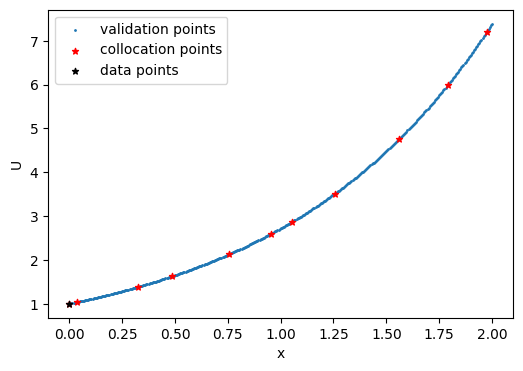

In [9]:
#### Visualizing the data points / collocation points / valdiation points
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x_validation, np.exp(x_validation), s=1, label='validation points')
ax.scatter(x_f_train, np.exp(x_f_train), s=20, color='red', marker='*', label='collocation points')
ax.scatter(x_train, u_train, s=20, color='black', marker='*', label='data points')
ax.set_ylabel('U')
ax.set_xlabel('x')
plt.legend()
plt.show()

In [10]:
### Start training
start_time = time.time()
it_list, loss_list, eq_loss_list, val_it_list, val_loss_list = model.train(niter, learning_rate)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

u_pred_val, f_pred_val = model.predict(tf.cast(x_validation, dtype=data_type))

It: 9, Train Loss: 2.2666e+01, Data Loss: 6.0413e+00, Eq Loss: 1.6624e+01, Val Loss: 1.1747e+01 Time: 0.33
It: 19, Train Loss: 2.8956e+00, Data Loss: 6.4259e-01, Eq Loss: 2.2530e+00, Val Loss: 2.5006e+00 Time: 0.41
It: 29, Train Loss: 2.2873e+00, Data Loss: 9.2644e-03, Eq Loss: 2.2780e+00, Val Loss: 2.9459e+00 Time: 0.37
It: 39, Train Loss: 1.0257e+00, Data Loss: 9.0350e-02, Eq Loss: 9.3534e-01, Val Loss: 6.1966e-01 Time: 0.34
It: 49, Train Loss: 6.3043e-01, Data Loss: 4.8269e-01, Eq Loss: 1.4774e-01, Val Loss: 1.9046e-01 Time: 0.26
It: 59, Train Loss: 4.4146e-01, Data Loss: 4.6639e-02, Eq Loss: 3.9482e-01, Val Loss: 3.8841e-01 Time: 0.22
It: 69, Train Loss: 3.2089e-01, Data Loss: 1.1961e-01, Eq Loss: 2.0128e-01, Val Loss: 1.7088e-01 Time: 0.23
It: 79, Train Loss: 2.8747e-01, Data Loss: 5.3210e-02, Eq Loss: 2.3426e-01, Val Loss: 2.1080e-01 Time: 0.23
It: 89, Train Loss: 2.5460e-01, Data Loss: 9.7761e-02, Eq Loss: 1.5684e-01, Val Loss: 1.3421e-01 Time: 0.25
It: 99, Train Loss: 2.3018e-0

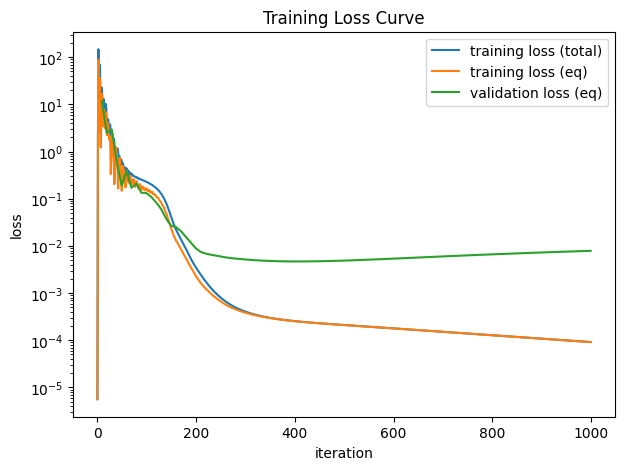

In [11]:
%matplotlib inline

######################################################################
############################# Plotting ###############################
######################################################################



fig, ax = plt.subplots(figsize=(7,5))
ax.plot(it_list, loss_list, label='training loss (total)')
ax.plot(it_list, eq_loss_list, label='training loss (eq)')
ax.plot(val_it_list, val_loss_list, label='validation loss (eq)')
ax.set_title('Training Loss Curve')
ax.set_yscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
plt.legend()
plt.show()

Text(0.5, 1.0, 'equation residual')

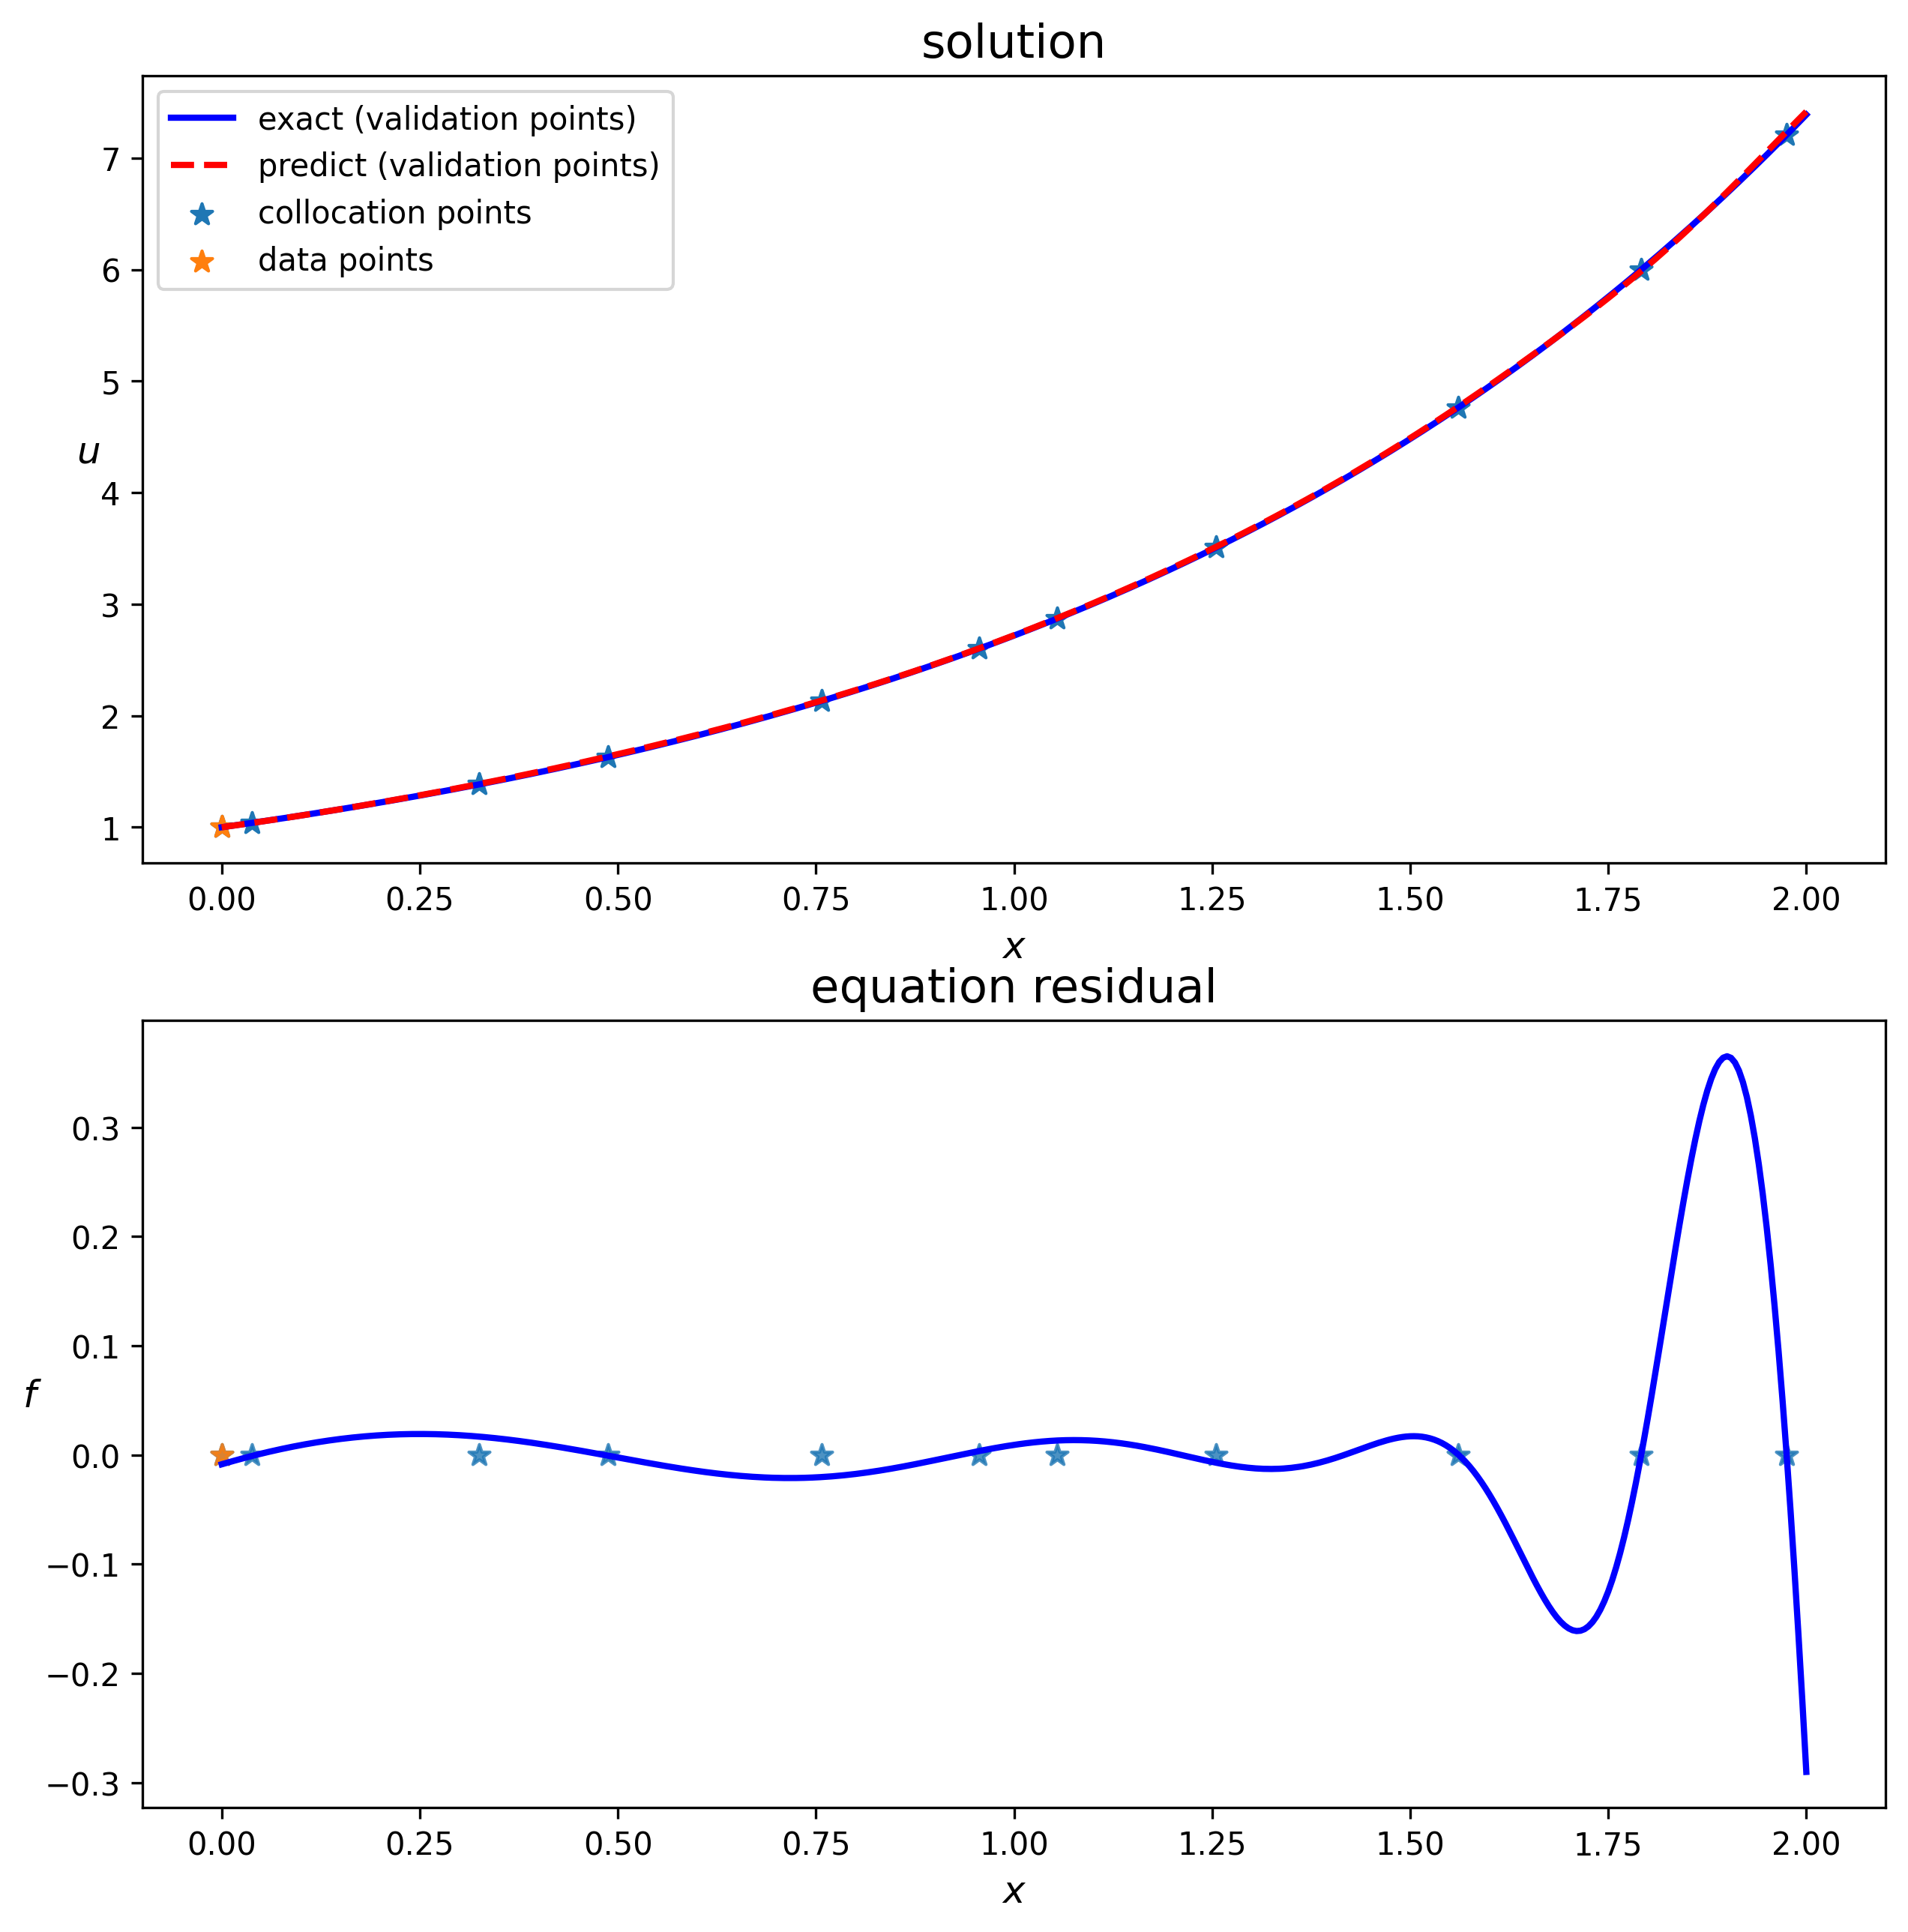

In [12]:
fig = plt.figure(figsize = [10, 10], dpi = 300)

ax = plt.subplot(211)
ax.plot(x_validation, u_validation, 'b-', linewidth = 2, label = 'exact (validation points)')
ax.plot(x_validation, u_pred_val, 'r--', linewidth = 2, label = 'predict (validation points)')
ax.scatter(x_f_train, np.exp(x_f_train), marker='*', s=50, label = 'collocation points')
ax.scatter(x_train, u_train, marker='*', s=50, label = 'data points')

ax.set_xlabel('$x$', fontsize = 12)
ax.set_ylabel('$u$', fontsize = 12, rotation = 0)
ax.set_title('solution', fontsize = 15)
plt.legend()


ax = plt.subplot(212)
ax.plot(x_validation, f_pred_val, 'b-', linewidth = 2)
ax.scatter(x_f_train, np.zeros(len(x_f_train)), marker='*', s=50, label = 'collocation points', alpha=0.8)
ax.scatter(x_train, np.zeros(len(x_train)), marker='*', s=50, label = 'data points', alpha=0.8)

ax.set_xlabel('$x$', fontsize = 12)
ax.set_ylabel('$f$', fontsize = 12, rotation = 0)
ax.set_title('equation residual', fontsize = 15)